In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import time

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import mygene
regions = ["BLA", "VTA", "CPU", "HIP", "PFC", "NAC"]

index_arrs = []
# DATA_PATH = "../data/0917/"
DATA_PATH = "../GAN-WGCNA/Dataset/"

for i, region in enumerate(regions):

    df = pd.read_csv(DATA_PATH + "%s_sample_averaged_profile.csv" % region, index_col = 0)
    index_arrs.append(df.index)

intersected_index = index_arrs[0] & index_arrs[1] & index_arrs[2] & index_arrs[3] & index_arrs[4] & index_arrs[5]
union_index = index_arrs[0] | index_arrs[1] | index_arrs[2] | index_arrs[3] | index_arrs[4] | index_arrs[5]

mg = mygene.MyGeneInfo()
ens = union_index # or intersected_index 
ginfo = mg.querymany(ens, scopes='ensembl.gene')
ensembl_to_symbol_info_hash = {}
# miss_table = pd.read_csv("missing_genes_from_may_2015.CSV")
# total = pd.read_csv("gene_table_from_ucsf_BMS270_ens79.csv", index_col = 0)

for g in ginfo:
    if g["query"] not in ensembl_to_symbol_info_hash.keys() and "symbol" in g.keys():
        if "name" in g.keys():
            ensembl_to_symbol_info_hash[g["query"]] = g["symbol"] + ": " + g["name"]
        else:
            ensembl_to_symbol_info_hash[g["query"]] = g["symbol"]            
    else:
        ensembl_to_symbol_info_hash[g["query"]] = g["query"] + ":" + "missing"
#         print(miss_table[miss_table["Ensembl Gene ID"] == g["query"]]["Associated Gene Name"])
#         print(g["query"])
        
symbol_to_ensemble_hash = {}

for ens in ensembl_to_symbol_info_hash.keys():
    symbol_to_ensemble_hash[ensembl_to_symbol_info_hash[ens].split(":")[0]] = ens

C:\Users\TAEHYE~1\AppData\Local\Temp/ipykernel_8356/406443781.py:13: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  intersected_index = index_arrs[0] & index_arrs[1] & index_arrs[2] & index_arrs[3] & index_arrs[4] & index_arrs[5]
C:\Users\TAEHYE~1\AppData\Local\Temp/ipykernel_8356/406443781.py:14: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  union_index = index_arrs[0] | index_arrs[1] | index_arrs[2] | index_arrs[3] | index_arrs[4] | index_arrs[5]


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-14715...done.
Finished.
2 input query terms found dup hits:
	[('ENSMUSG00000094002', 2), ('ENSMUSG00000100417', 2)]
259 input query terms found no hit:
	['ENSMUSG00000000325', 'ENSMUSG00000003178', 'ENSMUSG00000021745', 'ENSMUSG00000024952', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [5]:
def gene_profile_raw(fig, axe, gene, region = "BLA"):
    DATA_PATH = "../GAN-WGCNA/Dataset/"
    averaged_profile = []
    df = pd.read_csv(DATA_PATH + "%s_sample_averaged_profile.csv" % region, index_col = 0)
    
    for i in tqdm(range(0, 42)):
        epoch_averaged_profile = []
        for epoch in range(40000, 51000, 1000):
            profile = np.load(r"./20210325/0824_%s_%s_epoch_profile_full_concated.npy" % (region, epoch))
            epoch_averaged_profile.append(profile[100*i:(i+1)*100, np.where(df.index==gene)[0]])
        axe.plot(np.mean(epoch_averaged_profile, axis=0), color="black", alpha = 0.1)


#     for epoch in range(40000, 51000, 1000):
#         profile = np.load(r"D:/20210325/0824_%s_%s_epoch_profile_full_concated.npy" % (region, epoch))
#         for i in range(0, np.shape(profile)[0] // 100):
        
#             plt.plot(profile[100*i:(i+1)*100, np.where(  df.index==gene)[0]], color="black", alpha = 0.01)
#         # averaged_profile.append(profile)
    
    axe.plot(df.loc[gene].values, color="black")

    axe.set_xlabel("Simulation Step", fontsize = 25)
    axe.set_ylabel("Scaled expression lv", fontsize = 25)
#     axe.set_title("%s in %s" % (ensembl_to_symbol_info_hash[gene].split(":")[0], region), fontsize = 25)
    axe.set_ylim(0,1.0)
#     plt.axhline(y=0.2, color = 'red', linestyle='--')
#     plt.axhline(y=0, color="black")

def single_gene_volcano(fig, axe, gene, region = "BLA",):


    df_log2fc =  pd.read_csv(r"0312_deg_integrated_df-%s.csv" % region, index_col = 0)
    df_pval = pd.read_csv(r"0324_deg_integrated_df_PValue-%s.csv" % region, index_col = 0)
    
    tmp_x_coor = []
    tmp_y_coor = []
    tmp_color = []
    
    for i in tqdm(range(0, 99)):
        
        tmp_x_coor.append(df_log2fc.loc[gene][i])
        tmp_y_coor.append(-math.log(df_pval.loc[gene][i], 10))
        tmp_color.append(i)
        if i == 0:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "start", fontsize = 25)
        if i == 49:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "1 week", fontsize = 25)
        if i == 98:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "2 week", fontsize = 25)    

    axe.scatter(tmp_x_coor, tmp_y_coor, c=tmp_color, cmap=plt.cm.YlOrRd)
#     axe.set_title( ensembl_to_symbol_info_hash[gene].split(":")[0] + " in " + region, fontsize = 25)
    # r'$\sin (x) \ \cos (x) \ \tan (x)$ _2(FoldChange)'
    axe.set_xlabel(r"$log_{2}(FoldChange)$", fontsize = 25)
    axe.set_ylabel(r"$-log_{10}(P.value)$", fontsize = 25)
#     plt.xlim(-0.5, 0.5)
#     plt.ylim(0,1.0)
    axe.axvline(x=0.2, color = 'black')
    axe.axvline(x=-0.2, color = 'black')

    axe.axhline(y=1.3, color = 'black')
    return tmp_x_coor, tmp_y_coor
    
def gene_profile_logFC(fig, axe, gene, region = "BLA"):

    df_log2fc =  pd.read_csv(r"0312_deg_integrated_df-%s.csv" % region, index_col = 0)
    axe.plot(df_log2fc.loc[gene].values)
    axe.set_xlabel("Simulation Step", fontsize = 25)
    axe.set_ylabel(r"$log_{2}(FoldChange)$", fontsize = 25)
#     axe.set_title("%s in %s" % (ensembl_to_symbol_info_hash[gene].split(":")[0], region), fontsize = 25)
    axe.set_ylim(-0.5,0.5)
    axe.axhline(y=0.2, color = 'red', linestyle='--')
    axe.axhline(y=-0.2, color = 'red', linestyle='--')
    axe.axhline(y=0, color="black")

def single_gene_volcano_2week(fig, axe, gene, region = "BLA",):

    df_log2fc =  pd.read_csv(r"0312_deg_integrated_df-%s.csv" % region, index_col = 0)
    df_pval = pd.read_csv(r"0324_deg_integrated_df_PValue-%s.csv" % region, index_col = 0)
    
    tmp_x_coor = []
    tmp_y_coor = []
    tmp_color = []
    
    for i in [98]:#tqdm(range(0, 99)):
        
        tmp_x_coor.append(df_log2fc.loc[gene][i])
        tmp_y_coor.append(-math.log(df_pval.loc[gene][i], 10))
        tmp_color.append(i)
        if i == 0:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "start", fontsize = 25)
        if i == 49:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "1 week", fontsize = 25)
        if i == 98:
            axe.text(df_log2fc.loc[gene][i], -math.log(df_pval.loc[gene][i], 10), "2 week", fontsize = 25)    

    axe.scatter(tmp_x_coor, tmp_y_coor, c="red", cmap=plt.cm.YlOrRd)
#     axe.set_title( ensembl_to_symbol_info_hash[gene].split(":")[0] + " in " + region, fontsize = 25)
    
    axe.set_xlabel(r"$log_{2}(FoldChange)$", fontsize = 25)
    axe.set_ylabel(r"$-log_{10}(P.value)$", fontsize = 25)
    axe.set_xlim(0, 0.25)
    axe.set_ylim(0,9)
    axe.axvline(x=0.2, color = 'black')
    axe.axhline(y=1.3, color = 'black')

  0%|          | 0/42 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: './20210325/0824_NAC_40000_epoch_profile_full_concated.npy'

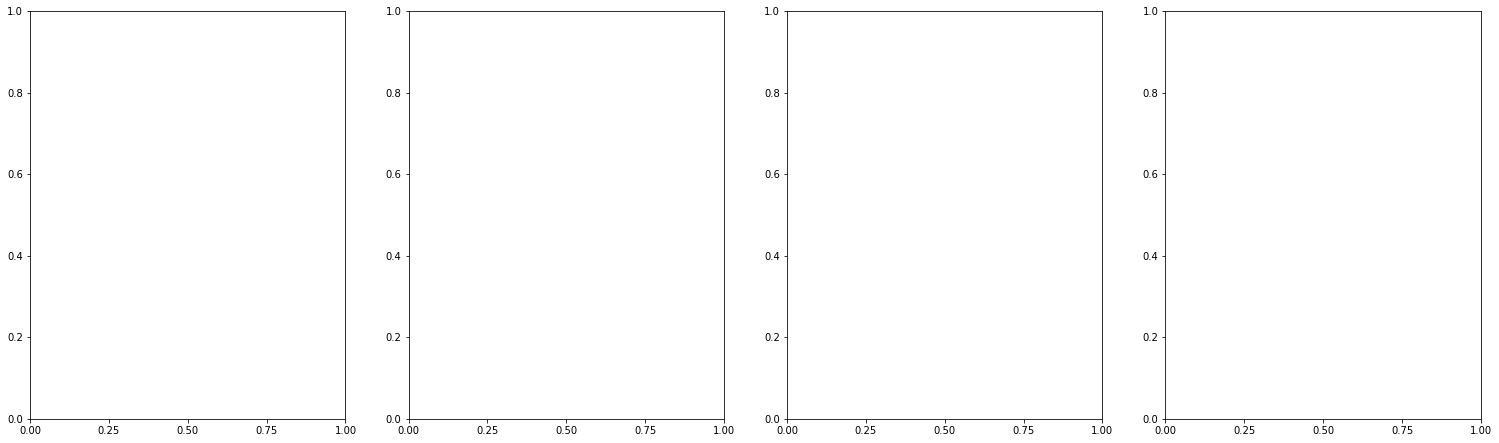

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4)
# fig.rcParams['axes.facecolor'] = 'white'

fig.set_size_inches((26, 7.5))
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

# gene_sym = "Zfp51" 
region = "NAC"
# fig.suptitle("%s in %s" % (gene_sym, region), fontsize = 50)

gene_profile_raw(fig, axes[0],symbol_to_ensemble_hash["Zfp51"], region = region)
single_gene_volcano_2week(fig, axes[1],symbol_to_ensemble_hash["Zfp51"], region = region)
single_gene_volcano(fig, axes[2],symbol_to_ensemble_hash["Zfp51"], region = region)
gene_profile_logFC(fig, axes[3],symbol_to_ensemble_hash["Zfp51"], region = region)

fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

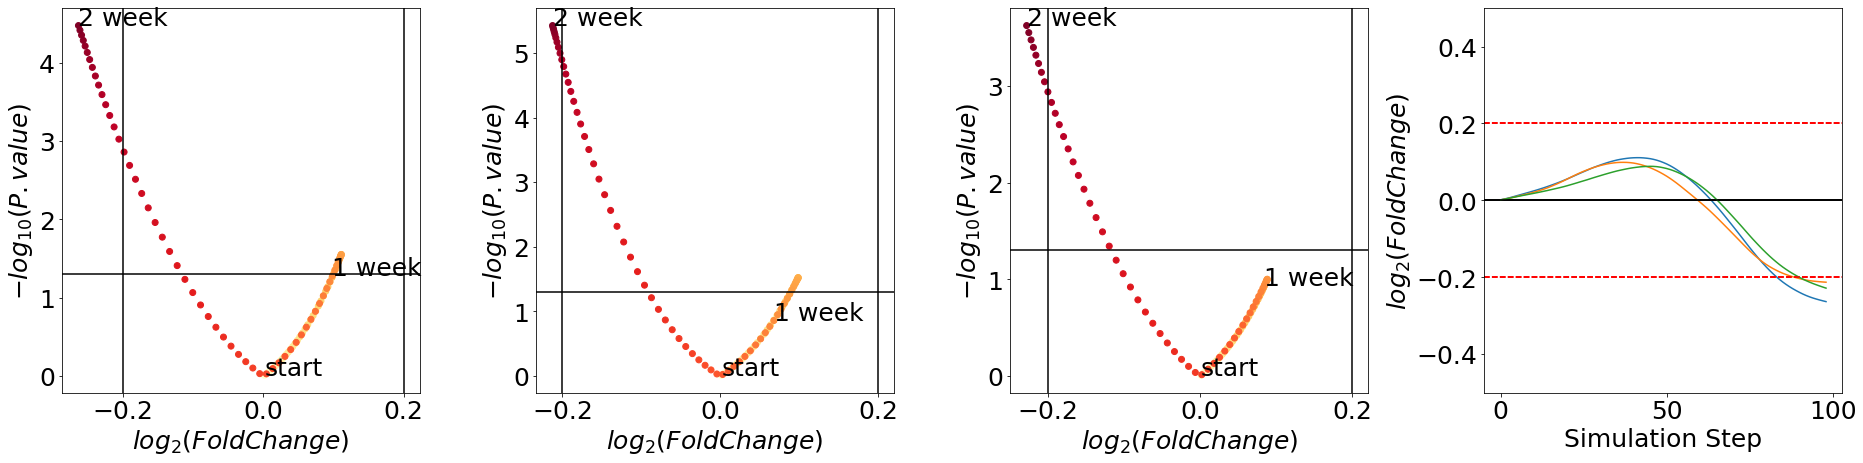

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4)
# fig.rcParams['axes.facecolor'] = 'white'

fig.set_size_inches((26, 7.5))
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

# gene_sym = "Zfp51" 
region = "NAC"
# fig.suptitle("%s in %s" % (gene_sym, region), fontsize = 50)

single_gene_volcano(fig, axes[0],symbol_to_ensemble_hash["Alcam"], region = region)
single_gene_volcano(fig, axes[1],symbol_to_ensemble_hash["Celf4"], region = region)
single_gene_volcano(fig, axes[2],symbol_to_ensemble_hash["Cdh11"], region = region)
gene_profile_logFC(fig, axes[3],symbol_to_ensemble_hash["Alcam"], region = region)
gene_profile_logFC(fig, axes[3],symbol_to_ensemble_hash["Celf4"], region = region)
gene_profile_logFC(fig, axes[3],symbol_to_ensemble_hash["Cdh11"], region = region)

fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

KeyError: 'Gm22887'

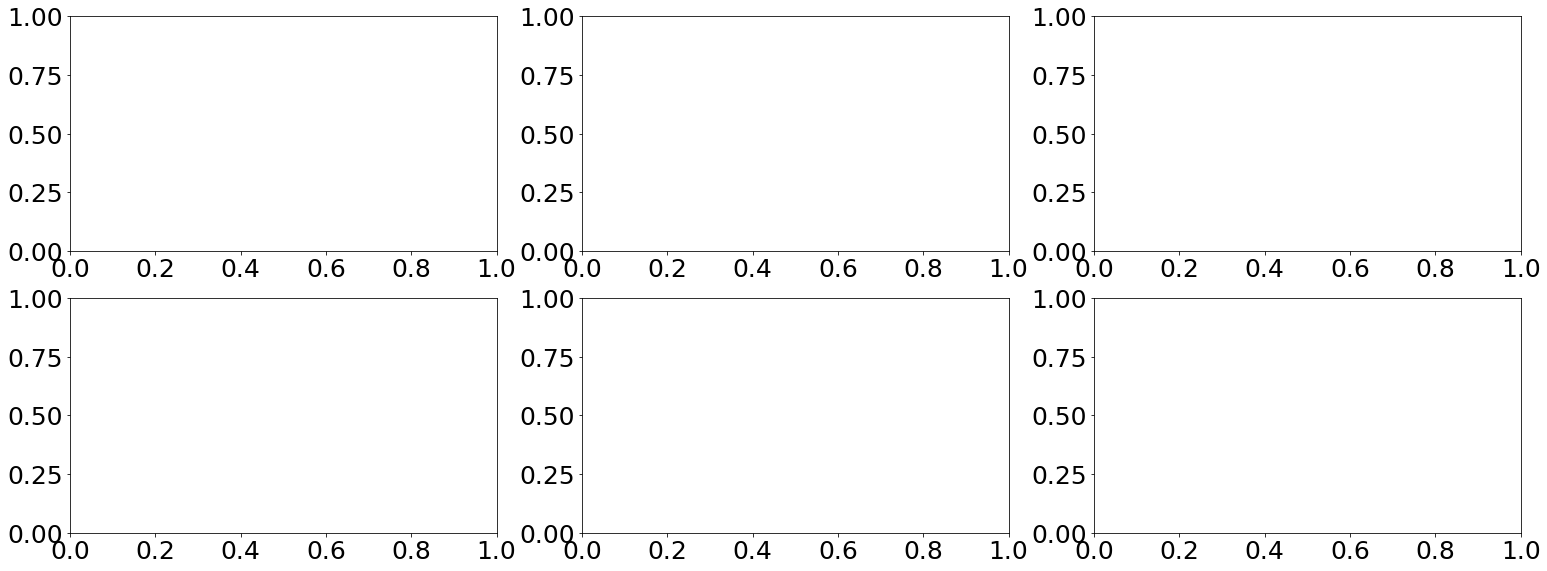

In [9]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

regions = ["BLA", "CPU", "NAC", "PFC", "HIP", "VTA"]
    
def draw_venn(fig, axe, region):
    rDEG = []
    for ind in range(1, 100):
        rdeg = pd.read_csv(r"./Results/%s_rescued_DEG%s.csv" % (region, "{:02d}".format(ind)), sep="\t")
        if not 0 == len(rdeg[(abs(rdeg["logFC"]) >= 0.2) & (rdeg["P.Value"] <= 0.05)].index):
            rDEG.extend(rdeg[(abs(rdeg["logFC"]) >= 0.2) & (rdeg["P.Value"] <= 0.05)].index)
    DEG_dfs = []
    df_DEG = pd.read_csv("./20210220/" + "%s-DEG.csv" % region, index_col = 0)
    
    out= venn2([set([ symbol_to_ensemble_hash[sym] for sym in df_DEG.index.values]), set(rDEG)], ('DEG', 'rDEG'), ax=axe)    
    # print(set([symbol_to_ensemble_hash[sym] for sym in df_DEG.index.values]) - set(rDEG))
    
    out.get_label_by_id("100").set_x(-0.75)
#     out.get_label_by_id("110").set_x(-0.35)
    out.get_label_by_id("110").set_y(0.25)
    
    for text in out.set_labels:
        text.set_fontsize(25)
    for x in range(len(out.subset_labels)):
        if out.subset_labels[x] is not None:
            out.subset_labels[x].set_fontsize(25)
    
    axe.set_title(region, fontsize =25)

    
    
fig, axes = plt.subplots(nrows=2, ncols=3)#, sharex=True)#, sharey=True)
fig.set_size_inches((26,9.5))

plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

for i, region in enumerate(tqdm(regions)):
    draw_venn(fig, axes[i // 3,i % 3], region)
    
# fig.suptitle("Overlap of DEG and rDEG", fontsize = 50)
# fig.tight_layout(rect=[0.03, 0.03, 1, 0.97])

plt.show()